# Plane Wave Fitting on Simulated Data
14th December,2021  \
Author: Reet Mhaske \
Reference: https://gfzpublic.gfz-potsdam.de/rest/items/item_43213_6/component/file_56078/content

plane wave fitting by iterating over all possible values of phi \
On multiple iterations of the code, it was observed that the estimated backazimuth is independent of the the initial velocity \
hence, we start with v=2000m/s and later on finding the estimate for backazimuth, we find the velocity of wave assuming that \
the wave propagates along the line of backazimuth, and by using the data of receivers that line on this line

In [1]:
# importing the requiered libraries

import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import random
random.seed(0)
np.random.seed(0)

import toa as toa 

funtion that returns time of wave onset in the detector 

In [2]:
def time_measured(t,xdatafile,ydatafile,df=810):
    x_data=np.array(toa.pd.read_csv(xdatafile))
    y_data=np.array(toa.pd.read_csv(ydatafile))
    time=np.linspace(0,t,810)
    time_arrival_x=toa.time_of_arrival(x_data,time,df=810)
    time_arrival_y=toa.time_of_arrival(y_data,time,df=810)
     
    time_arrival=np.add(time_arrival_x,time_arrival_y)/2
 
    return time_arrival
    

(100, 810)


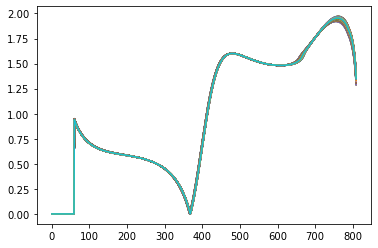

In [3]:
t=20
x_data=np.array(toa.pd.read_csv('recx_data_circ100.csv'))
y_data=np.array(toa.pd.read_csv('recy_data_circ100.csv'))
time=np.linspace(0,t,810)
time_arrival_x=toa.time_of_arrival(x_data,time,df=810)
time_arrival_y=toa.time_of_arrival(y_data,time,df=810)
     
time_arrival=np.add(time_arrival_x,time_arrival_y)/2
print(np.shape(x_data))


##### initialize no. of receivers, apparent horizontal velocity of sound, max frequency of source 

In [4]:
n_rec=100# number of receivers, to be kept odd for first run

rec_pos_act= np.zeros(shape =(n_rec,2))  # Assigning thr actual receiver position

v = 2000# m/s ### velocity of propagation (in sand)
freq=10 #Hz, max recorded frequency
lamda=v/freq# wavelength
distance_limit=2000#m,  l=2000m  > 10 times lamda 

##### initialize position of source and  receivers 

In [5]:
#setting source configuration randomly

#-->a=random.randrange(distance_limit-distance_limit/10,distance_limit*5) # sourec distance must be more than or equal to d , limits set here are arbitary within this acceptance
#-->b=random.randrange(distance_limit-distance_limit/10,distance_limit*5)
#-->src=(b,a)
#-->random.randrange(distance_limit-distance_limit/10,distance_limit*5)

#new source
src=(1000-11000,1000-11000)
#setting different receiver configurations

#uncomment following line for random distribution
rec_pos_act=np.random.normal(0,100,size=(n_rec,2))


#uncomment following line for linear distribution
#-->for i in range(0,n_rec):
    #rec_pos_act[i,1]=0
    #rec_pos_act[i,0]=(i-(n_rec-1)/2)*5 #first receievr at (-50,0) last at (50,0), all in line, distance 5 between them 


#uncomment following line for circular distribution    
#for i in range(0,n_rec):
 #   rec_pos_act[i,0]=100*cos(i*2*np.pi/n_rec)
  #  rec_pos_act[i,1]=100*sin(i*2*np.pi/n_rec) 
x_pos=np.array(toa.pd.read_csv('recx_pos_circ100.csv'))
y_pos=np.array(toa.pd.read_csv('recy_pos_circ100.csv'))
#rec_pos_act[0]=(0,0) #first receiver always at origin
rec_pos_act[:,0]=x_pos.reshape(100,)
rec_pos_act[:,1]=y_pos.reshape(100,)
rec_pos_act-=(11000,11000)




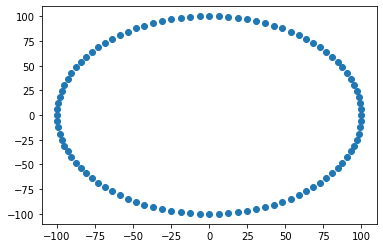

In [6]:
plt.scatter(rec_pos_act[:,0],rec_pos_act[:,1])

initialize time recordings by time of arrival, introduce noise in time and position

(100, 1)
(100, 1)
rec_pos_mes:   (100, 2)  t_Rec_real:  (100, 1)


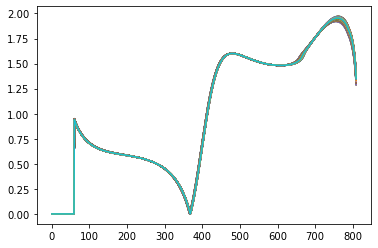

In [7]:


t_rec_ideal = np.zeros(shape =(n_rec,))  # time recorded in each receiver; form: (index of receiver,time) 


t_noise=np.random.normal(0,5/(v),size=(n_rec,1))

#introduce noise in position
rec_pos_noise=np.random.normal(0,2.5,size=(n_rec,2))

rec_pos_mes= rec_pos_act # + rec_pos_noise  # rec_pos_mes stores[(x1,y1),(x2,y2),..] 



#initialising time recordings

#-->for i in range (0,n_rec):
 #-->   t_rec_ideal[0:n_rec] = np.sqrt((rec_pos_mes[0:n_rec,0]-src[0])**2 + (rec_pos_mes[0:n_rec,1]-src[1])**2)/v


#redefine the time recordings from data files

t_rec_ideal=time_measured(20,'recx_data_circ100.csv','recy_data_circ100.csv')
print(np.shape(t_rec_ideal))
print(np.shape(t_noise))


### t_Rec_real has form [[rec1 recording], [rec2 recording]]




# introduce noise in time
t_Rec_real=t_rec_ideal #+ t_noise


# time difference between time recordings wrt receiver 1st rec, 
#in the form : time recorded by receiver at ith position - time recorded by 1st receiver 
t_diff=np.zeros(shape=(n_rec,))
for i in range(0,n_rec):
    t_diff[i]=t_rec_ideal[i]-t_rec_ideal[0]
    
print("rec_pos_mes:  ",np.shape(rec_pos_mes)," t_Rec_real: ",np.shape(t_Rec_real))   
    
    
    

We iterate over all values of the backazimuth $\phi$ such that it minimizes the error expression for 
N receivers:
$\hat{s} = \min_{s}\sum_{i=1}^{N} (\tau_{i} - r_{i}.s)^2 $
where i is the index of the receivers
$\tau_{i}$ is the time difference for $i^{th}$ receiver
where the slowness vector $\vec{s}$ is defined as:
$\vec{s} = (-\frac{\sin{\phi}}{v}, -\frac{\cos{\phi}}{v})$

In [8]:
#function to return the error expression for a particular s, v and given configuration of receivers : 

def sum_of_errors(s_x,s_y,n_rec,rec_loc,time_diff):
    ''' returns the error expression for particular  slowness vector s , apparent horizontal velocity v, receiver positions, and time differences\
        input s in form of s_x and s_y ( x and y coordinate ) \
        input n_rec: number of receivers \
        input rec_loc: 2-D array for receiver location , in form [(x_1,y_1),...(x_n_rec,y_n_rec)]\
        input time_diff: 1-D array for time difference [(t_i)]'''  
    soe=0 # sume of errors
    # find sum over all receivers
    for i in range (0,n_rec):
        soe+=(time_diff[i]-s_x*rec_loc[i,0]-s_y*rec_loc[i,1])**2
    return soe    

In [9]:
#function to estimate slowness by iterating over backazimuth

def estimate_backazimuth(v,n_rec,rec_loc,time_diff):
    ''' returns estimated backazimuth and final error for the estimated backazimuth\
    input v: apparent horizontal velocity\
    inputn_rec: number of receivers\
    input rec_loc: 2-D array for receiver locations in form [(x_1,y_2)]\
    input time_diff: 1-D array for time difference [(t_i)]'''
    phi_estimated=0
    error=10000
    phi_range = np.linspace(0,2*np.pi,200000)
    for phi in phi_range :
            soe=sum_of_errors(-np.sin(phi)/v,-np.cos(phi)/v,n_rec,rec_loc,time_diff)  
            #print(s_x_temp,s_y_temp)
            #print(soe)
            #print(s_x_temp,s_y_temp
            if ( error>soe):
                error =soe
                phi_estimated=phi
    if (sum_of_errors(-np.sin(np.pi-phi_estimated)/v,-np.cos(np.pi-phi_estimated)/v,n_rec,rec_loc,time_diff)<error) :
        error=sum_of_errors(-np.sin(np.pi-phi_estimated)/v,-np.cos(np.pi-phi_estimated)/v,n_rec,rec_loc,time_diff)
        phi_estimated=np.pi-phi_estimated
    return (phi_estimated,error)  

Calling the above function to estimate velocity and error

In [10]:
phi_actual=np.arctan2(src[0],src[1]) #y first for arctan2,rotate axis (N is x now), so input x first
if (phi_actual<0):
    phi_actual+=2*np.pi
              
print("actual angle: ", phi_actual)
phi_estimated,final_error=estimate_backazimuth(v,n_rec,rec_pos_mes,t_diff)
print("phi_estimated :",phi_estimated,"\nfinal_error: ", final_error)

index_of_nearest_chip=int((5*np.pi/2-phi_estimated)%(2*np.pi)*100/(2*np.pi))
index_of_farthest_chip=int((5*np.pi/2-phi_estimated-np.pi)%(2*np.pi)*100/(2*np.pi))

print("index of receiver nearest to src on estimated backazimuth line: ",index_of_nearest_chip)
print("index of receiver farthest from src on estimated backazimuth line:   ", index_of_farthest_chip)
print("index of receiver to receive the wave first: ",list(t_Rec_real).index(t_Rec_real.min()))
print("indx of receiver to receive the wave last: ",list(t_Rec_real).index(t_Rec_real.max()))
print("index of receiver nearest to src on actual backazimuth line:   ",int((5*np.pi/2-phi_actual)%(2*np.pi)*100/(2*np.pi)))
print("index of receiver farthest from src on actual backazimuth line:   ",int((5*np.pi/2-phi_actual-np.pi)%(2*np.pi)*100/(2*np.pi)))



v=(np.sqrt(np.sum(np.square(np.subtract(rec_pos_mes[index_of_farthest_chip],rec_pos_mes[index_of_nearest_chip] )))))/\
(t_Rec_real[index_of_farthest_chip]-t_Rec_real[index_of_nearest_chip])/10
print(v) 

d=v*(t_Rec_real[index_of_nearest_chip]+t_Rec_real[index_of_farthest_chip])/2
print("difference in backazimuth: ",phi_estimated-phi_actual,"\npercentage error in backazimuth: ",((phi_estimated)/phi_actual-1)*100,"%"  )
#src_position_estimated=(t)
estimated_position=(d*np.sin(phi_estimated),d*np.cos(phi_estimated))
print("d: ",d,"estimated position: ", estimated_position)
diff_in_loc=np.sqrt(np.sum(np.square(np.subtract(estimated_position,src))))
print("diff in location: " ,  diff_in_loc,"m ")

print("percentage error in position: ",diff_in_loc/(np.sqrt(src[0]**2+src[1]**2) )*100,"%")


actual angle:  3.92699081699
phi_estimated : 3.98830323117 
final_error:  0.0917284358402
index of receiver nearest to src on estimated backazimuth line:  61
index of receiver farthest from src on estimated backazimuth line:    11
index of receiver to receive the wave first:  65
indx of receiver to receive the wave last:  15
index of receiver nearest to src on actual backazimuth line:    62
index of receiver farthest from src on actual backazimuth line:    12
[ 1618.]
difference in backazimuth:  0.0613124141877 
percentage error in backazimuth:  1.56130780654 %
d:  [ 16530.] estimated position:  (array([-12382.71195067]), array([-10950.31254105]))
diff in location:  3627.78449348 m 
percentage error in position:  25.6523101602 %


After knowing the backazimuth, we find the indices of receivers that lie on this line of  estimated backazimuth \
We find the indices of receivers ling along the line of true backazimuth and also the one that receive the wave the first and \
last (labeled the nearest and farthest from src respectively)

In [11]:
index_of_nearest_chip=int((5*np.pi/2-phi_estimated)%(2*np.pi)*100/(2*np.pi))
index_of_farthest_chip=int((5*np.pi/2-phi_estimated-np.pi)%(2*np.pi)*100/(2*np.pi))

print("index of receiver nearest to src on estimated backazimuth line: ",index_of_nearest_chip)
print("index of receiver farthest from src on estimated backazimuth line:   ", index_of_farthest_chip)
print("index of receiver to receive the wave first: ",list(t_Rec_real).index(t_Rec_real.min()))
print("indx of receiver to receive the wave last: ",list(t_Rec_real).index(t_Rec_real.max()))
print("index of receiver nearest to src on actual backazimuth line:   ",int((5*np.pi/2-phi_actual)%(2*np.pi)*100/(2*np.pi)))
print("index of receiver farthest from src on actual backazimuth line:   ",int((5*np.pi/2-phi_actual-np.pi)%(2*np.pi)*100/(2*np.pi)))

index of receiver nearest to src on estimated backazimuth line:  61
index of receiver farthest from src on estimated backazimuth line:    11
index of receiver to receive the wave first:  65
indx of receiver to receive the wave last:  15
index of receiver nearest to src on actual backazimuth line:    62
index of receiver farthest from src on actual backazimuth line:    12


In [16]:
v=np.sqrt(np.sum(np.square(np.subtract(rec_pos_mes[index_of_farthest_chip],rec_pos_mes[index_of_nearest_chip] ))))/ \
                                    (t_Rec_real[index_of_farthest_chip]-t_Rec_real[index_of_nearest_chip])
#finding velocity using the receivers that lie on the line of estimated backazimuth
print(v)


[ 16180.]


### The velocity of propagation
the estimated velocity is greater than the permissible range ( ~1000m/s to 2000 m/s), we manually scale it down by 10

In [17]:
v=v/10

We plot the wave onset time for the receivers, \
the receiver hae been indexed starting from the receiever at y=, and positive x extreme of the circle and going anticlockwise 

Text(0, 0.5, 'time of wave onset (in sec)')

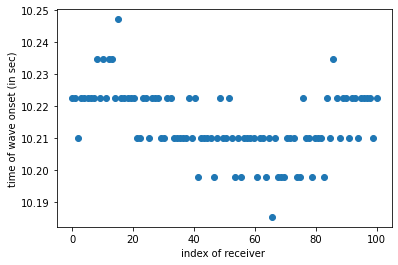

In [19]:
plt.scatter(np.linspace(0,100,100),t_Rec_real)
plt.xlabel('index of receiver ')
plt.ylabel('time of wave onset (in sec)')


In [46]:

print("pi- phi_estimated :",np.pi-phi_estimated)
print(" difference in backazimuth (diff of pi): ",np.pi-phi_estimated-phi_actual," percentage error : ",((np.pi-phi_estimated)/phi_actual-1)*100,"%"  )


pi- phi_estimated : -0.846710577585
 difference in backazimuth (diff of pi):  -4.77370139457  percentage error :  -121.561307807 %


###  Plot the results 

In [47]:
x=np.linspace(0,2*np.pi,2000)
y=np.zeros(shape=(2000,))
for i in range(0,2000):
    y[i]=sum_of_errors(-sin(x[i])/v,-cos(x[i])/v,n_rec,rec_pos_mes,t_diff)

Text(0, 0.5, 'error in arbitary units')

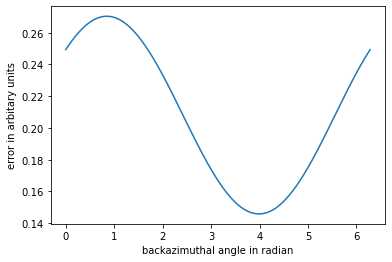

In [48]:
plt.plot(x,y)
plt.xlabel("backazimuthal angle in radian")
plt.ylabel("error in arbitary units")


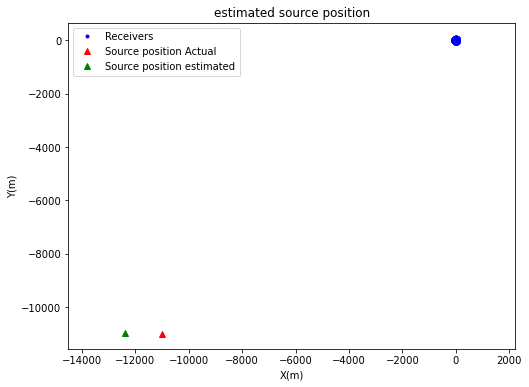

In [50]:
x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position


plt.figure(figsize=(8,6))
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(-11000,-11000,'r^',label='Source position Actual')
d=v*t_Rec_real[0]
plt.plot(d*np.sin(phi_estimated),d*np.cos(phi_estimated),'g^',label='Source position estimated')

#plt.plot(d*np.sin(np.pi-phi_estimated),d*np.cos(np.pi-phi_estimated),'g^',label='Source position estimated')
#plt.plot(d*np.sin(np.pi/2-phi_estimated),d*np.cos(np.pi/2-phi_estimated),'g^',label='Source position estimated')
plt.plot()
plt.legend()
#plt.xlim(-500,500)
#plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')

plt.title('estimated source position')
plt.show()

     

Key Limitations:

Cause of the error is because the estimated position assumes that first receiver (at index 0) is at origin 

Configurations tried so far:
linear,
gaussian(negative results),
circular

Noise introduced in position has standard deviation 2.5m; and that in time has standard deviation 5/v

Distance of source from receivers should be more than 10 times the wavelength

the error in backazimuth is magnified on multiplying by distance as is observed 